In [1]:
%matplotlib inline

morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'

In [2]:
def update_rest_rband(um_r_rest_old, r_rest_old, um_r_rest_new):
    """
    """
    dr = r_rest_old - um_r_rest_old
    return um_r_rest_new + dr

def update_observed_rband(r_obs_old, r_rest_old, r_rest_new):
    """
    """
    dr = r_obs_old - r_rest_old
    return r_rest_new + dr


In [3]:
import os
dirname = "/Volumes/simulation_data_2018/protoDC2_v4"
basename = "v4.1.dust136.1substep.all.aph_reduced.hdf5"

fname = os.path.join(dirname, basename)

from astropy.table import Table
mock = Table.read(fname, path='data')

mock.rename_column('um_restframe_extincted_sdss_abs_magr', 'um_mag_r_rest')
mock.rename_column('um_restframe_extincted_sdss_gr', 'um_gr_rest')
mock.rename_column('um_restframe_extincted_sdss_ri', 'um_ri_rest')
mock['um_mag_g_rest'] = mock['um_gr_rest'] + mock['um_mag_r_rest']
mock['um_mag_i_rest'] = mock['um_mag_r_rest'] - mock['um_ri_rest']
print(mock.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['um_host_halo_mvir', 'um_obs_sm', 'um_obs_sfr', 'um_redshift', 'um_sfr_percentile', 'um_upid', 'um_mpeak', 'um_mag_r_rest', 'um_gr_rest', 'um_ri_rest', 'um_is_on_red_sequence_gr', 'um_is_on_red_sequence_ri', 'isCentral', 'redshift', 'hostHaloMass', 'mag_g_rest', 'mag_g_obs', 'mag_r_rest', 'mag_r_obs', 'mag_i_rest', 'mag_i_obs', 'mag_z_rest', 'mag_z_obs', 'um_mag_g_rest', 'um_mag_i_rest']


In [4]:
from cosmodc2.stellar_mass_remapping import lift_high_mass_mstar

mock['new_mstar'] = lift_high_mass_mstar(
        mock['um_mpeak'], mock['um_obs_sm'], mock['redshift'], 
        z_table=[0.35, 0.5, 1], 
        slope_table=[0.5, 0.65, 0.8], pivot_table=[13.25, 13, 12.5])

In [5]:
from cosmodc2.sdss_colors import magr_monte_carlo

mock['new_um_mag_r_rest'] = magr_monte_carlo(mock['new_mstar'], mock['redshift'])

In [6]:
#  Estimate the new restframe Galacticus r-band
mock['new_mag_r_rest'] = update_rest_rband(
    mock['um_mag_r_rest'], mock['mag_r_rest'], mock['new_um_mag_r_rest'])

#  Estimate the new observed Galacticus r-band
mock['new_mag_r_obs'] = update_observed_rband(
    mock['mag_r_obs'], mock['mag_r_rest'], mock['new_mag_r_rest'])

#  Estimate the new observed UniverseMachine r-band
mock['new_um_mag_r_obs'] = update_observed_rband(
    mock['mag_r_obs'], mock['mag_r_rest'], mock['new_um_mag_r_rest'])


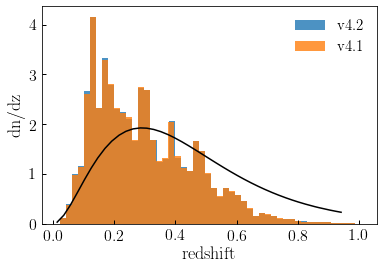

In [7]:
fname = "/Users/aphearin/Desktop/deep2_data.txt"
X = np.loadtxt(fname)
z = X[:, 0]
dndz = X[:, 1]

fig, ax = plt.subplots(1, 1)

rmask_old = mock['mag_r_obs'] < 22
rmask_new = mock['new_mag_r_obs'] < 22
__=ax.hist(mock['redshift'][rmask_new], normed=True, bins=50, alpha=0.8, 
           label=r'${\rm v4.2}$', color=mblue)
__=ax.hist(mock['redshift'][rmask_old], normed=True, bins=50, alpha=0.8,
          label=r'${\rm v4.1}$', color=morange)

__=ax.plot(z, dndz, color='k')

legend = ax.legend()
xlabel = ax.set_xlabel(r'${\rm redshift}$')
ylabel = ax.set_ylabel(r'${\rm dn/dz}$')
